# CS584: DETECTION OF DUPLICATE QUESTIONS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install boto

In [ ]:
# Importing Libraries
# SEABORN AND MATPLOTLIB is for Data Visualization, we will use those in EDA as well.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Importing all the necessary Libraries

In [ ]:
import keras.backend as K

In [ ]:
import pickle

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import re

In [ ]:
from time import time

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM
from keras.layers import merge
from keras.callbacks import ModelCheckpoint


In [ ]:
import itertools
import datetime
import boto

In [ ]:
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from tensorflow.keras.optimizers import Adam, Adadelta

In [ ]:
import tensorflow.compat.v2 as tf

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Here we are storing our data in dataframe named varibale "DataFrame"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS 584 Natural Language Processing/Project/questions.csv')

In [ ]:
# To chech whether our data contains Null values or not we will check basic information of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
# To double verify we will check missing values as well 
df.isnull().sum()

# As per results there are 1 missing values in Question 1 and 2 in Question 2, we will handle this misisng values later.

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
# Also we need to check whether our data contains Duplicate values or not
df.duplicated().sum()

# As per reuluts we can say that there are no duplicate value sin our data

0

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# To check the number of rows and columns of data (Dimensions) we will use df.shape
df.shape

(404351, 6)

In [ ]:
# Let's check some stats of our duplicate and non-duplicate question pairs
print(df['is_duplicate'].value_counts())

0    255045
1    149306
Name: is_duplicate, dtype: int64


In [ ]:
# Let's check that how much percentage of duplicate and non duplicate question pairs are there
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)

# As per results 63.07% of data is non-duplicate and 36.92% od data is duplicate

0    63.07515
1    36.92485
Name: is_duplicate, dtype: float64


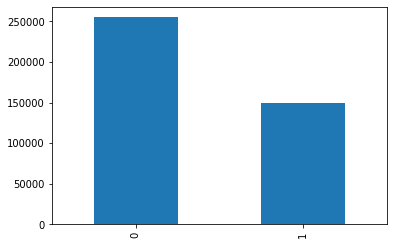

In [ ]:
# Let's do visulization of this stats we calculated using barplot
df['is_duplicate'].value_counts().plot(kind='bar')

# From our graph we can say that our data is bit unbalanced, it is more 0 side

In [ ]:
# we have around 4lakh+ questions in Question1 attribute and around 4lakh+ in Question2 attribute
# So from total 8lakh questions let's check how many are repeated and non-repeated

Question_id = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Unique Question: ', np.unique(Question_id).shape[0])
x = Question_id.value_counts()>1
print('Repeated Questions: ', x[x].shape[0])


# As per results we can say that there are 7,89,801 Unique Questions and 13,698 Duplicate Questions

Unique Question:  789801
Repeated Questions:  13698


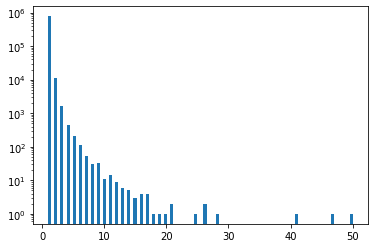

In [ ]:
# Let's make a histogram plot for above outcomes
plt.hist(Question_id.value_counts().values, bins = 100)
plt.yscale('log')
plt.show()

In [ ]:
# Whene we are working in a such a huge dataset it is to difficult to implement model, 
# even it is also hard for machine to run 4 lkh+ rows and give output, it is too much time consuming,
# in order to reduce our time complexity we are minimizing our data set into 30000
NEW_df = df.sample(30000, random_state = 1)
# we are using random_state parameter so that everytime when we select random_state=1 we get same random pairs

In [ ]:
# Let's check do we have any duplicate values or not in our new_df
NEW_df.duplicated().sum()

# As per the outcome we do not have any duplicate rows here

0

In [ ]:
# Let's make a Questions Data frame in which we only have question pairs, we will avaoid other attributes here
ques_df = NEW_df[['question1','question2']]
ques_df.head()

,question1,question2
236588,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...
284623,What's a good alternative cut to brisket if I ...,What is the best wood to smoke brisket?
37445,Which horror movie has the most jump scares?,Is it possible to create a good horror film wi...
299330,What's your ethical take on the vegetarian vs ...,Can a non vegetarian date a vegetarian?
204421,What are some good tips for young biotech ente...,What must young entrepreneurs know before they...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # Importing Count Vectorizer function 
# merging texts
merge_questions_df = list(ques_df['question1']) + list(ques_df['question2']) # Creating list of Question1 and Question 2

v = CountVectorizer(max_features=3000) # limiting features to 3000
q1_arr, q2_arr = np.vsplit(v.fit_transform(merge_questions_df).toarray(),2) # Implimenting transform

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape
# As per result we now have 6000 feautures, from that 3000 bag of words are of question1 and 3000 bag of words are for question2

(30000, 6000)

In [ ]:
temp_df['is_duplicate'] = NEW_df['is_duplicate'] # Checking that do we have any duplicate questions in our temp data frame or not

In [ ]:
temp_df.shape

(30000, 6001)

In [ ]:
# Now without doing anything let's randomly train our model using Random Forest Classifier so that we can altleast get the accuracy of our model without doing anything
from sklearn.model_selection import train_test_split

# Imported train-test_split function from the model_selection class of sklearn library

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)
#Splited our data in 80%-20% ratio, 80% data for Training and remaining 20% for testing

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Imported RandomForestClaasifier for Training model
from sklearn.metrics import accuracy_score #imported accurancy_score function to calculate accuracy of our model after getting trained
rf = RandomForestClassifier() # Implementing model
rf.fit(X_train,y_train) # Fitting training data
y_pred = rf.predict(X_test) # Predicting data
ac = accuracy_score(y_test,y_pred) # Calculationg accuracy score
Accuracy_Percentage = ac*100

In [ ]:
# Random Forest Classifier Model Accuracy
Accuracy_Percentage

73.98333333333333

In [ ]:
# Let's apply another algorithm as well so that we can compare both algorithm's accuracy without doing anything

In [ ]:
!pip install xgboost

In [ ]:
# so another algorith we are applying XG Boost Classifier
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
ac2 = accuracy_score(y_test,y_pred)
accuracy_Percentag_xgb = ac2*100

In [ ]:
# XG Boost Classifier Model accuracy
accuracy_Percentag_xgb

67.95

###  So, as per SG Boost Classifier Model's accuracy and Random Forect Classifier Model's accuracy, we are getting accuracy as below without doing any manipulation with our dataset:
### Random Forest Classifier: 73.98%
### XGBoost Classifier: 67.95%


0    19023
1    10977
Name: is_duplicate, dtype: int64
0    63.41
1    36.59
Name: is_duplicate, dtype: float64


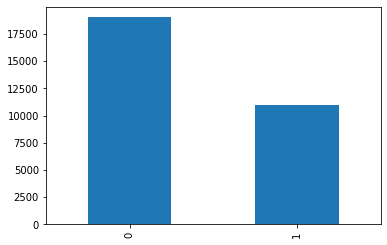

In [ ]:
# As we created plot for 4lakh+ rows, here we are making the same plot but for 30000 rows
# Distribution of duplicate and non-duplicate questions

print(NEW_df['is_duplicate'].value_counts())
print((NEW_df['is_duplicate'].value_counts()/NEW_df['is_duplicate'].count())*100)
NEW_df['is_duplicate'].value_counts().plot(kind='bar')

In [ ]:
# Let's check that in this new data frame is there any repeated question pairs or not, if yes than also check the number

qid = pd.Series(NEW_df['qid1'].tolist() + NEW_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

# As per results there are 59836 unique questions and 153 repeated questions

Number of unique questions 59841
Number of questions getting repeated 141


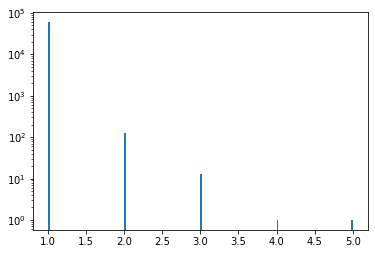

In [ ]:
# Let's make a histogram plot for above outcomes

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

###To increase the accuracy of our model and to making it more perfect We will add more features in our data, which is also known as feature engineering

# We will make seven new feautures as per mentioned below:

### **1.Character Length of Question1: Length_Q1**
### **2.Character Length of Question2: Length_Q2**
### **3.Number of words in Question1: #_words_Q1**
### **4.Number of words in Question2: #_words_Q2**
### **5.Number of Common UNIQUE Words: #_Common_Words**
### **6.Total Number in Q1 + Total + number of words in Question2: Total_Words**
### **7.Word Common/Word Total: share_word**

In [ ]:
# Now Let's Begain Feature Engineering

NEW_df['Length_Q1'] = NEW_df['question1'].str.len() 
NEW_df['Length_Q2'] = NEW_df['question2'].str.len()

# Here we are now adding two more features which are Question 1 length and Question2 length

In [ ]:
NEW_df.head()

# as per the outcoms we can see that our 2 new features are added in the data frame

,id,qid1,qid2,question1,question2,is_duplicate,Length_Q1,Length_Q2
236588,236588,466074,466075,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0,120,119
284623,284623,413904,559402,What's a good alternative cut to brisket if I ...,What is the best wood to smoke brisket?,0,61,39
37445,37445,74608,74609,Which horror movie has the most jump scares?,Is it possible to create a good horror film wi...,0,44,64
299330,299330,587921,587922,What's your ethical take on the vegetarian vs ...,Can a non vegetarian date a vegetarian?,0,76,39
204421,204421,403323,403324,What are some good tips for young biotech ente...,What must young entrepreneurs know before they...,0,56,63


In [ ]:
# Here we are adding 2 more new features
# one is Number of words in Question1 and second is number if words in Question2
NEW_df['#_words_Q1'] = NEW_df['question1'].apply(lambda row: len(row.split(" ")))
NEW_df['#_words_Q2'] = NEW_df['question2'].apply(lambda row: len(row.split(" ")))

In [ ]:
# Here we are making one function which will help us to make a new feature to find common words between Question1 set and Question2 set
def number_of_Common_Words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [ ]:
# Here we are applying that function to add one more feature in our data frame
NEW_df['#_common_words'] = NEW_df.apply(number_of_Common_Words, axis=1)

In [ ]:
# Here we are making one more function to find the Total Number in Q1 + Total + number of words in Question2: Total_Words

def Total_Words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [ ]:
# Here we are applying that function which we created above

NEW_df['Total_Words'] = NEW_df.apply(Total_Words, axis=1)

In [ ]:
# Finally, here we are making our last feature which is - Word Common/Word Total: share_word
NEW_df['Share_Words'] = round(NEW_df['#_common_words']/NEW_df['Total_Words'],2)

In [ ]:
NEW_df.head()

# As per the results we can see that our all features are added in the dataset

,id,qid1,qid2,question1,question2,is_duplicate,Length_Q1,Length_Q2,#_words_Q1,#_words_Q2,#_common_words,Total_Words,Share_Words
236588,236588,466074,466075,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0,120,119,22,22,19,40,0.48
284623,284623,413904,559402,What's a good alternative cut to brisket if I ...,What is the best wood to smoke brisket?,0,61,39,12,8,1,20,0.05
37445,37445,74608,74609,Which horror movie has the most jump scares?,Is it possible to create a good horror film wi...,0,44,64,8,12,3,20,0.15
299330,299330,587921,587922,What's your ethical take on the vegetarian vs ...,Can a non vegetarian date a vegetarian?,0,76,39,12,7,1,17,0.06
204421,204421,403323,403324,What are some good tips for young biotech ente...,What must young entrepreneurs know before they...,0,56,63,9,10,2,19,0.11


Minimum Characters Per Question:-  1
Maximum Characters Per Question:-  345
Average Number of Characters Per Question:-  59


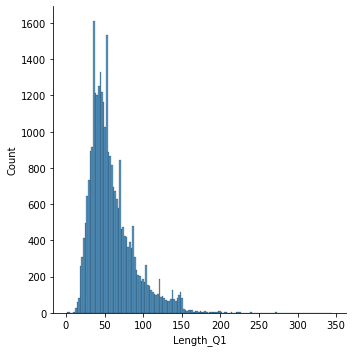

In [ ]:
# Now let's do a quick analysis of our features so that we can check that everything is going good or not
# Let's start with our 1st feature "Length_Q1"

sns.displot(NEW_df['Length_Q1'])
print('Minimum Characters Per Question:- ',NEW_df['Length_Q1'].min())
print('Maximum Characters Per Question:- ',NEW_df['Length_Q1'].max())
print('Average Number of Characters Per Question:- ',int(NEW_df['Length_Q1'].mean()))

# as per the EDA we can say that there are
# Minimum Characters Per Question:-  1
# Maximum Characters Per Question:-  413
# Average Number of Characters Per Question:-  59

Minimum Characters Per Question:-  2
Maximum Characters Per Question:-  1151
Average Number of Characters Per Question:-  60


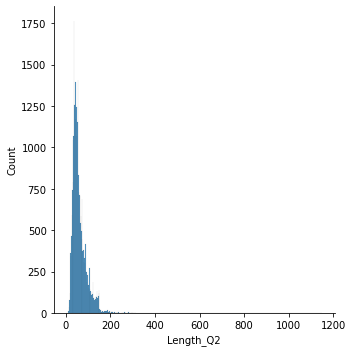

In [ ]:
# Data Visualization for 2nd feature "Length_Q2"

sns.displot(NEW_df['Length_Q2'])
print('Minimum Characters Per Question:- ',NEW_df['Length_Q2'].min())
print('Maximum Characters Per Question:- ',NEW_df['Length_Q2'].max())
print('Average Number of Characters Per Question:- ',int(NEW_df['Length_Q2'].mean()))

# as per the EDA we can say that there are
# Minimum Characters Per Question:-  5
# Maximum Characters Per Question:-  364
# Average Number of Characters Per Question:-  60

Minimum Characters Per Question 1
Maximum Characters Per Question 68
Average Number of Characters Per Question 10


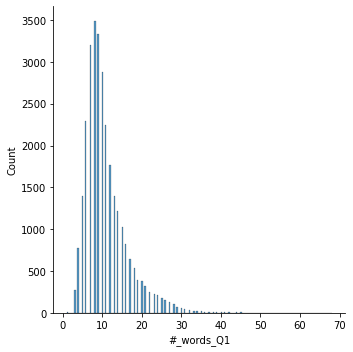

In [ ]:
# Data Visualization for 3rd feature "#_words_Q1"

sns.displot(NEW_df['#_words_Q1'])
print('Minimum Characters Per Question',NEW_df['#_words_Q1'].min())
print('Maximum Characters Per Question',NEW_df['#_words_Q1'].max())
print('Average Number of Characters Per Question',int(NEW_df['#_words_Q1'].mean()))

# as per the EDA we can say that there are
# Minimum Characters Per Question:-  1
# Maximum Characters Per Question:-  79
# Average Number of Characters Per Question:-  10

Minimum Characters Per Question 1
Maximum Characters Per Question 237
Average Number of Characters Per Question 11


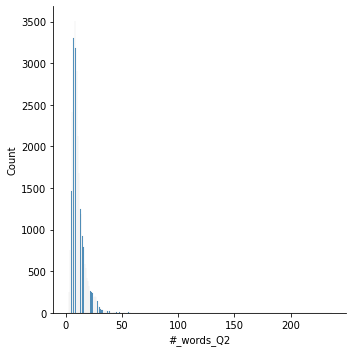

In [ ]:
# Data Visualization for 4th feature "#_words_Q2"

sns.displot(NEW_df['#_words_Q2'])
print('Minimum Characters Per Question',NEW_df['#_words_Q2'].min())
print('Maximum Characters Per Question',NEW_df['#_words_Q2'].max())
print('Average Number of Characters Per Question',int(NEW_df['#_words_Q2'].mean()))

# as per the EDA we can say that there are
# Minimum Characters Per Question:-  2
# Maximum Characters Per Question:-  77
# Average Number of Characters Per Question:-  11

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


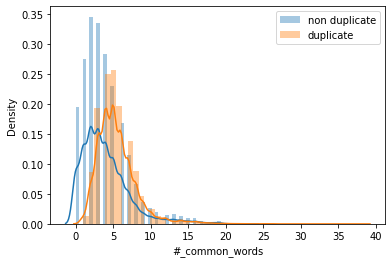

In [ ]:
# Here in EDA for Non-Diplicate and Duplicate we will use differenst visualization, instead of using displot we will use distplot which 
# will be differentiate between 2 categories which are Non-Diplicate and Duplicate one.

# Data Visualization for 5th feature "#_common_words"

sns.distplot(NEW_df[NEW_df['is_duplicate'] == 0]['#_common_words'],label='non duplicate')
sns.distplot(NEW_df[NEW_df['is_duplicate'] == 1]['#_common_words'],label='duplicate')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


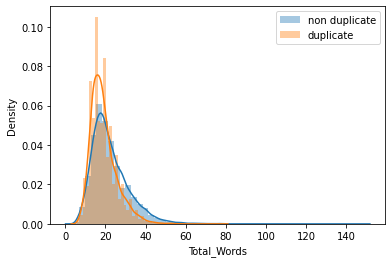

In [ ]:
# Data Visualization for 6th feature "Total_Words"

sns.distplot(NEW_df[NEW_df['is_duplicate'] == 0]['Total_Words'],label='non duplicate')
sns.distplot(NEW_df[NEW_df['is_duplicate'] == 1]['Total_Words'],label='duplicate')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


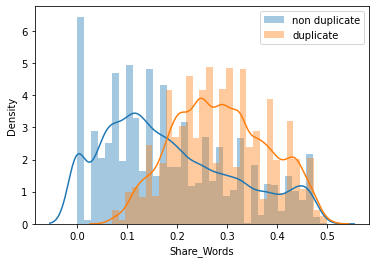

In [ ]:
# Data Visualization for 7th and last feature "Share_Words"

sns.distplot(NEW_df[NEW_df['is_duplicate'] == 0]['Share_Words'],label='non duplicate')
sns.distplot(NEW_df[NEW_df['is_duplicate'] == 1]['Share_Words'],label='duplicate')
plt.legend()
plt.show()

In [ ]:
# Now we will make two different data frames in which we will store 2 kind of different data
# First is Questions_df in which we will store only questions
# Second is Final_df in which we will store is_duplicate and our seven features

In [ ]:
Questions_df = NEW_df[['question1','question2']]

In [ ]:
Questions_df.head()

,question1,question2
236588,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...
284623,What's a good alternative cut to brisket if I ...,What is the best wood to smoke brisket?
37445,Which horror movie has the most jump scares?,Is it possible to create a good horror film wi...
299330,What's your ethical take on the vegetarian vs ...,Can a non vegetarian date a vegetarian?
204421,What are some good tips for young biotech ente...,What must young entrepreneurs know before they...


In [ ]:
Final_df = NEW_df.drop(columns=['id','qid1','qid2','question1','question2'])

In [ ]:
Final_df

,is_duplicate,Length_Q1,Length_Q2,#_words_Q1,#_words_Q2,#_common_words,Total_Words,Share_Words
236588,0,120,119,22,22,19,40,0.48
284623,0,61,39,12,8,1,20,0.05
37445,0,44,64,8,12,3,20,0.15
299330,0,76,39,12,7,1,17,0.06
204421,0,56,63,9,10,2,19,0.11
...,...,...,...,...,...,...,...,...
371187,1,49,49,8,7,6,15,0.40
292863,0,60,91,14,18,2,31,0.06
66615,0,86,73,15,13,3,28,0.11
381430,0,37,39,6,11,0,17,0.00


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer   # Here we import CountVectorizer funtion from feature_extraction.text class of sklearn library for merging texts
# Here we will use Count Vectorizer function for merging texts
Ques = list(Questions_df['question1']) + list(Questions_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(Ques).toarray(),2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= Questions_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= Questions_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [ ]:
Final_df = pd.concat([Final_df, temp_df], axis=1)
print(Final_df.shape)
Final_df.head()

(30000, 6008)


,is_duplicate,Length_Q1,Length_Q2,#_words_Q1,#_words_Q2,#_common_words,Total_Words,Share_Words,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
236588,0,120,119,22,22,19,40,0.48,0,0,...,0,0,0,0,0,0,0,0,0,0
284623,0,61,39,12,8,1,20,0.05,0,0,...,0,0,0,0,0,0,0,0,0,0
37445,0,44,64,8,12,3,20,0.15,0,0,...,0,0,0,0,0,0,0,0,0,0
299330,0,76,39,12,7,1,17,0.06,0,0,...,0,0,0,0,0,0,0,0,0,0
204421,0,56,63,9,10,2,19,0.11,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Final_df.iloc[:,1:].values,Final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
ac = accuracy_score(y_test,y_pred)     

In [ ]:
# RandomForestClassifier Accuracy Percentage
ac_score = ac*100
print(ac_score)

76.73333333333333


### Before when we run the model over accuracy was only 73.98, after adding seven new features we do a improvement of 2.75%, still so far to go

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
xgb_ac = accuracy_score(y_test,y_pred1)

In [ ]:
# XGBClassifier Accuracy Percentage
xgb_ac_score = xgb_ac*100
print(xgb_ac_score)

73.8


### Before when we run the model over accuracy was only 67.95%, after adding seven new features we do a improvement of 5.85%, still so far to go

### Now we will use some advance methodologoes and algorithm to make our model more accurate.

### As we can see from the above methodology, we used XGBoost Classifiers and the Random Forest Classifiers Algorithm, which appears to be insufficient for such a large dataset with over 4 lakh rows. Even after adding more features, our accuracy does not improve significantly, so here comes the advanced NLP algorithm in a game.Now, we'll employ **advanced methodologies like Word2Vec, LSTM**, and others that we learnt in class to refine the model and make it more accurate.

In [ ]:
# Splitting data into 80:20 ratio and storing into 2 varibales names training_data and testing_data
training_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(training_data.index)

In [ ]:
# Checking shape of our training data
training_data.shape


# As per the result w can say that we have 6 columns or Attributes or Default Features in our data and 
# 3,23,481 rows, which is very huge

(323481, 6)

In [ ]:
# Checking shape of our training data
testing_data.shape

(80870, 6)

In [ ]:
training_data

,id,qid1,qid2,question1,question2,is_duplicate
368490,368490,721163,721164,What is an embedding problem?,What is embedded?,0
244232,244232,480998,480999,How do you deal with the side effects regardin...,What are the side effects for using Proactiv? ...,1
54076,54076,107607,107608,"Why will we, not jews or muslims, decide wheth...",Why don't smokers quit smoking when it's obvio...,0
274264,274264,539316,539317,Is it hard to code a game like agar.io?,How do you program a game like agar.io?,0
335454,335454,657704,657705,How does Snapchat's screenshot notification pr...,"How exactly does Snapchat detect, if it's user...",0
...,...,...,...,...,...,...
79271,79271,157474,157475,How do I run a Google Apps Script spreadsheet ...,Can I run Apple apps on my rooted Android phone?,0
145379,145379,287687,287688,How do you know if someone is lying to you?,How do we know whether someone is lying to you?,1
39013,39013,77722,77723,What is the best way to clean dog poop off shoes?,Interacting with Police: If search dogs are af...,0
140813,140813,278725,278726,Should I study computer engineering if I don't...,What is the better subject to study if I am in...,0


In [ ]:
# Let's print the number of trainig and testing examples, so that we can see the distribution
print(f"Number of training examples: {training_data.shape[0]}")
print(f"Number of testing examples: {testing_data.shape[0]}")

Number of training examples: 323481
Number of testing examples: 80870


In [ ]:
# Here we are storing GoogleNews-vectors-negative300.bin in word2vec_file_path, this file is downloaded from google it is very huge file, size: 3.64Gb
# We will use this file for loading key vectors of Word2Vec
word2vec_file_path = '/content/drive/MyDrive/CS 584 Natural Language Processing/Project/GoogleNewsvectorsnegative300.bin'

In [ ]:
Questions_DataFrame = ['question1', 'question2']

In [ ]:
df.shape

(404351, 6)

In [ ]:
stops = set(stopwords.words('english'))

def text2word_list(text):
    # Preprocessing and converting all texts to a list of words 
    text = str(text)
    text = text.lower()

    # Here we are cleaning the texts, by removing tokens, symbols, and different signs
    # this step is necessary to avoid noise in our model
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()

    return text


Vocabulary_Dictionary = dict()  
Inverse_Vocabulary_Dictionary = ['<unk>']
word2vec = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)
Questions_DataFrame = ['question1', 'question2']
# Here we are adding words in Vocabulary which we extracted from text
# Also we are skipping word which occurs or repeat more than one time
for DataFrame in [training_data]:
    for index, row in DataFrame.iterrows():
        for question in Questions_DataFrame:

            Ques2n_list = []

            for word in text2word_list(row[question]): # Here we are using the function 'text2word_list' which we made above

                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in Vocabulary_Dictionary:
                    Vocabulary_Dictionary[word] = len(Inverse_Vocabulary_Dictionary)
                    Ques2n_list.append(len(Inverse_Vocabulary_Dictionary)) # Appending length of Inverse Vocabulary
                    Inverse_Vocabulary_Dictionary.append(word)
                else:
                    Ques2n_list.append(Vocabulary_Dictionary[word])

            DataFrame.at[index , question] = Ques2n_list
                       
Embedding_Dimensions = 300
Embedd = 1 * np.random.randn(len(Vocabulary_Dictionary) + 1, Embedding_Dimensions)
Embedd[0] = 0 

for word, index in Vocabulary_Dictionary.items():
    if word in word2vec.vocab:
        Embedd[index] = word2vec.word_vec(word)

del word2vec

In [ ]:
Inverse_Vocabulary_Dictionary

# As per the outcomes we can see the Vocabulary which we created

['<unk>',
 'what',
 'is',
 'an',
 'embedding',
 'problem',
 'embedded',
 'how',
 'do',
 'you',
 'deal',
 'with',
 'the',
 'side',
 'effects',
 'regarding',
 'proactiv',
 'products',
 'are',
 'for',
 'using',
 'treated',
 'why',
 'will',
 'we',
 'not',
 'jews',
 'or',
 'muslims',
 'decide',
 'whether',
 'they',
 'can',
 'live',
 'us',
 'smokers',
 'quit',
 'smoking',
 'when',
 'it',
 'obvious',
 'them',
 'that',
 'this',
 'habit',
 'surely',
 'kill',
 'hard',
 'code',
 'game',
 'like',
 'agar',
 'io',
 'program',
 'does',
 'snapchat',
 'screenshot',
 'notification',
 'process',
 'work',
 'exactly',
 'detect',
 'if',
 'user',
 'takes',
 'did',
 'i',
 'lose',
 'money',
 'on',
 'stock',
 'market',
 'traders',
 'in',
 'find',
 'perimeter',
 'quarter',
 'circle',
 'enclosed',
 'square',
 '14cm',
 'sides',
 'authors',
 'state',
 'earth',
 '2',
 '3',
 'way',
 'galactic',
 'edge',
 '26',
 'million',
 'light',
 'years',
 'from',
 'center',
 'thousand',
 'order',
 'should',
 'put',
 'my',
 'educa

In [ ]:
# Here we are using pickle.dump function of Pickle library to store the object data to the file
# We can store file wherever we want to store by providing specific path of location.

pickle.dump( Vocabulary_Dictionary, open( "/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Training_Vocabulary_LSTM.p", "wb" ) )
pickle.dump( Inverse_Vocabulary_Dictionary, open( "/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Inverse_Vocabulary_Dictionary_Train_LSTM.p", "wb" ) )
pickle.dump( Embedd, open( "/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Embedded_Train_LSTM.p", "wb" ) )

In [ ]:
training_data

,id,qid1,qid2,question1,question2,is_duplicate
368490,368490,721163,721164,"[1, 2, 3, 4, 5]","[1, 2, 6]",0
244232,244232,480998,480999,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[1, 18, 12, 13, 14, 19, 20, 16, 7, 18, 12, 13,...",1
54076,54076,107607,107608,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[22, 8, 25, 35, 36, 37, 38, 39, 40, 41, 42, 43...",0
274264,274264,539316,539317,"[2, 39, 47, 48, 49, 50, 51, 52]","[7, 8, 9, 53, 49, 50, 51, 52]",0
335454,335454,657704,657705,"[7, 54, 55, 56, 57, 58, 59]","[7, 60, 54, 55, 61, 62, 39, 63, 64, 56]",0
...,...,...,...,...,...,...
79271,79271,157474,157475,"[7, 8, 66, 3072, 626, 321, 6051, 17259, 69, 11...","[32, 66, 3072, 2430, 321, 69, 100, 4828, 949, ...",0
145379,145379,287687,287688,"[7, 8, 9, 146, 62, 196, 2, 1004, 9]","[7, 8, 24, 146, 30, 196, 2, 1004, 9]",1
39013,39013,77722,77723,"[1, 2, 12, 117, 87, 644, 1132, 5301, 613, 2958]","[5265, 11, 2710, 134, 62, 465, 6116, 18, 548, ...",0
140813,140813,278725,278726,"[98, 66, 566, 392, 293, 62, 66, 8, 25, 50, 349]","[1, 2, 12, 421, 6105, 566, 62, 66, 395, 4097, ...",0


In [ ]:
X = training_data[Questions_DataFrame]
X.shape

(323481, 2)

In [ ]:
Maximum_Sequence_Length = max(training_data.question1.map(lambda x: len(x)).max(),
                              training_data.question2.map(lambda x: len(x)).max())

# Here we are spliiting our data into Validation, Training and Testing
Data_Validation_Size = 64696 
Training_Data_Size =194089
test_size = 64696
X = training_data[Questions_DataFrame]
Y = training_data['is_duplicate']

X_train = X.iloc[0:Training_Data_Size, :]
X_validation = X.iloc[Training_Data_Size:Training_Data_Size+Data_Validation_Size, :]
X_test = X.iloc[(Training_Data_Size+Data_Validation_Size):(Training_Data_Size+Data_Validation_Size+test_size), :]

Y_train = Y.iloc[0:Training_Data_Size]
Y_validation = Y.iloc[Training_Data_Size:Training_Data_Size+Data_Validation_Size]
Y_test = Y.iloc[Training_Data_Size+Data_Validation_Size:Training_Data_Size+Data_Validation_Size+test_size]

# Here "Left" is a input Question and "Right" is a Question to be checked

X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}

# Storing Values in the variables
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = Y_test.values

# Padding of the sequences up to Maximum_Sequence_Length
for DataFrame, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    DataFrame[side] = pad_sequences(DataFrame[side], maxlen=Maximum_Sequence_Length)

# Makeing whether everythng is going good or not
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)
assert X_validation['left'].shape == X_validation['right'].shape
assert len(X_validation['left']) == len(Y_validation)
assert X_test['left'].shape == X_test['right'].shape
assert len(X_test['left']) == len(Y_test)

In [ ]:
Maximum_Sequence_Length

# As per the output Maximum Length of Sequence is 212

212

In [ ]:
print(X_test)

# Printing X_test to check whether it contains any null value or not

{'left': array([[    0,     0,     0, ...,   164,   640,  6601],
       [    0,     0,     0, ..., 70558,    12,  7339],
       [    0,     0,     0, ...,   211,   925,    19],
       ...,
       [    0,     0,     0, ...,  5301,   613,  2958],
       [    0,     0,     0, ...,    25,    50,   349],
       [    0,     0,     0, ...,  2933,  2335,    59]], dtype=int32), 'right': array([[    0,     0,     0, ...,   164,   640,  6601],
       [    0,     0,     0, ...,  4397,  1184,  1455],
       [    0,     0,     0, ...,    31,   925,    19],
       ...,
       [    0,     0,     0, ...,   613,   100, 15986],
       [    0,     0,     0, ...,   780,  2462,   293],
       [    0,     0,     0, ...,   873,  2176,   369]], dtype=int32)}


In [ ]:
count = 0

# Making three different dictonaries to store Questions Length, Positive Question Length and Negative Question Length
Questions_Length_Dictionary = dict()
Positive_Questions_Length_Dictionary = dict()
Negative_Questions_Length_Dictionary = dict()

# Here we will increase count if Question is Not Duplicate and we will keep it constant if it is Duplicate
for index, row in training_data.iterrows():
    Ques1 = str(row["question1"])
    Ques2 = str(row["question2"])
    Ques1_Length = len(Ques1)
    Ques2_Length = len(Ques2)
    if Ques1_Length in Questions_Length_Dictionary:
        Questions_Length_Dictionary[Ques1_Length] = Questions_Length_Dictionary[Ques1_Length] + 1
    else:
        Questions_Length_Dictionary[Ques1_Length] = 1
    
    if Ques2_Length in Questions_Length_Dictionary:
        Questions_Length_Dictionary[Ques2_Length] = Questions_Length_Dictionary[Ques2_Length] + 1
    else:
        Questions_Length_Dictionary[Ques2_Length] = 1
    
    if bool(row["is_duplicate"]):
        if Ques1_Length in Positive_Questions_Length_Dictionary:
            Positive_Questions_Length_Dictionary[Ques1_Length] = Positive_Questions_Length_Dictionary[Ques1_Length] + 1
        else:
            Positive_Questions_Length_Dictionary[Ques1_Length] = 1

        if Ques2_Length in Positive_Questions_Length_Dictionary:
            Positive_Questions_Length_Dictionary[Ques2_Length] = Positive_Questions_Length_Dictionary[Ques2_Length] + 1
        else:
            Positive_Questions_Length_Dictionary[Ques2_Length] = 1
    else:
        if Ques1_Length in Negative_Questions_Length_Dictionary:
            Negative_Questions_Length_Dictionary[Ques1_Length] = Negative_Questions_Length_Dictionary[Ques1_Length] + 1
        else:
            Negative_Questions_Length_Dictionary[Ques1_Length] = 1

        if Ques2_Length in Negative_Questions_Length_Dictionary:
            Negative_Questions_Length_Dictionary[Ques2_Length] = Negative_Questions_Length_Dictionary[Ques2_Length] + 1
        else:
            Negative_Questions_Length_Dictionary[Ques2_Length] = 1
        
    count+=1

print(count)

323481


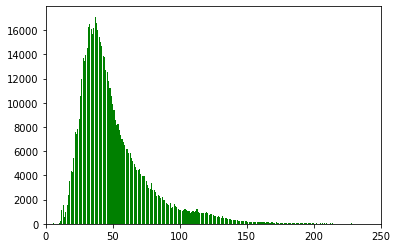

In [ ]:
# Now we will do a EDA(Exploratary Data Analysis) by Data Visualizationof
# Keys and Values of Question Length

plt.bar(list(Questions_Length_Dictionary.keys()), Questions_Length_Dictionary.values(), color='g')
plt.xlim(0,250)
plt.show()

# As per the graph we can say that the average question lenght is around between 30-60 characters
# Also some questions contains very high number of characters around between 100-200 range, so there are also big questions in our data

In [ ]:
print(X_train['left'].shape) # Checking shape of X_train of Left
print(X_train['right'].shape) # Checking shape of X_train of Right
print(X_validation['left'].shape) # Checking shape of X_Validation of Left
print(X_validation['right'].shape) # Checking shape of X_Validation of Right
print(X_test['left'].shape) # Checking shape of X_test of Left
print(X_test['right'].shape) # Checking shape of X_test of Right
print(Y_train.shape) # Checking shape of Y_train
print(Y_validation.shape) # Checking shape of Y_Validation
print(Y_test.shape) # Checking shape of Y_test

(194089, 212)
(194089, 212)
(64696, 212)
(64696, 212)
(64696, 212)
(64696, 212)
(194089,)
(64696,)
(64696,)


In [ ]:
!pip install mymodule 

  Created wheel for mymodule: filename=myModule-1.0.0-py3-none-any.whl size=1454 sha256=38d4e67928443b6e1bebf9de54e58057ac104cb5f9d4980e32f19f0f6d2f7548
  Stored in directory: /root/.cache/pip/wheels/ee/37/f2/73d77aee9ac5e6b4e187c42481a6ad1dfe736ed079dcfba914
Successfully built mymodule


In [ ]:
!pip install mypackage

     |████████████████████████████████| 146 kB 5.1 MB/s 
  Created wheel for mypackage: filename=Mypackage-0.1-py3-none-any.whl size=1813 sha256=4c56438c300785223d2e6b52c558cb62409d89239da8168c22dae501e841b79a
  Stored in directory: /root/.cache/pip/wheels/70/33/4d/a9a319067a95ea09a7e5a1d31dca913c15725934a548a4f539
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=912782454653c731dfb3406c96becc9df9b9b89bcc110698d4dee0f8fd165fc0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built mypackage pyperclip


In [ ]:
import myModule
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.layers import concatenate

In [ ]:
from keras.layers import Lambda

In [ ]:
from tensorflow.python.ops.gen_control_flow_ops import Merge
# Model variables
Number_Of_Hidden_Variables = 50
Gradient_Clipping_Norm = 1.25
Size_Of_Batch = 64
Number_Of_epoch = 25

def Exponent_Negative_Manhattan_Distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Giving Tensor Placeholders as Input
Left_IN = Input(shape=(Maximum_Sequence_Length,), dtype='int32')
Right_IN= Input(shape=(Maximum_Sequence_Length,), dtype='int32')

# This the Embedding layer 
Embedding_Layers = Embedding(len(Embedd), Embedding_Dimensions, weights=[Embedd], input_length=Maximum_Sequence_Length, trainable=False)

# Adding Left Input and Right Input to the embedding dimension 
Left_ENC= Embedding_Layers(Left_IN)
Right_ENC = Embedding_Layers(Right_IN)

# Here we are Initializing LSTM Model
LSTM_Shared = LSTM(Number_Of_Hidden_Variables)
Left_OUT = LSTM_Shared(Left_ENC)
Right_OUT = LSTM_Shared(Right_ENC)

# here we are Calculating Manhattan Distance to measure similarity between a pair of sequences
Manhattan_LSTM_Distance = Lambda(lambda x: Exponent_Negative_Manhattan_Distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([Left_OUT, Right_OUT])

# Here we are building our Model
Manhattan_LSTM = Model([Left_IN, Right_IN], [Manhattan_LSTM_Distance])
optimizer = Adam(clipnorm=Gradient_Clipping_Norm)
Manhattan_LSTM.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# here we are fitting our model and also passing 25 epochs so that we can increase our accuracy of model and reduce the loss
StartTime_Of_Training = time() 
Manhattan_LSTM_trained = Manhattan_LSTM.fit([X_train['left'], X_train['right']], Y_train, batch_size=Size_Of_Batch, epochs = Number_Of_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("The Total training time for {} epochs is {}".format(Number_Of_epoch, datetime.timedelta(seconds=time()-StartTime_Of_Training)))


Epoch 1/25
3033/3033 [==============================] - 90s 26ms/step - loss: 0.1709 - accuracy: 0.7524 - val_loss: 0.1558 - val_accuracy: 0.7838
Epoch 2/25
3033/3033 [==============================] - 78s 26ms/step - loss: 0.1500 - accuracy: 0.7898 - val_loss: 0.1474 - val_accuracy: 0.7908
Epoch 3/25
3033/3033 [==============================] - 79s 26ms/step - loss: 0.1419 - accuracy: 0.8025 - val_loss: 0.1431 - val_accuracy: 0.7979
Epoch 4/25
3033/3033 [==============================] - 79s 26ms/step - loss: 0.1362 - accuracy: 0.8128 - val_loss: 0.1394 - val_accuracy: 0.8085
Epoch 5/25
3033/3033 [==============================] - 79s 26ms/step - loss: 0.1320 - accuracy: 0.8192 - val_loss: 0.1369 - val_accuracy: 0.8126
Epoch 6/25
3033/3033 [==============================] - 80s 26ms/step - loss: 0.1284 - accuracy: 0.8247 - val_loss: 0.1352 - val_accuracy: 0.8145
Epoch 7/25
3033/3033 [==============================] - 80s 26ms/step - loss: 0.1255 - accuracy: 0.8304 - val_loss: 0.1336 -

In [ ]:
import h5py
Manhattan_LSTM.save('/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Manhattan_LSTM_Final_TrainCSV.h5')

In [ ]:
# Predicting X_training Left and Right

Training_Predictions = Manhattan_LSTM.predict([X_train['left'], X_train['right']], batch_size = Size_Of_Batch)
Training_Predictions = [item for sublist in Training_Predictions for item in sublist]

pickle.dump( Training_Predictions, open( "/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Predictions_LSTM_Final_TrainCSV.p", "wb" ) )


In [ ]:
# Predicting X_Validation Right and Left

Validating_Predictions = Manhattan_LSTM.predict([X_validation['left'], X_validation['right']], batch_size = Size_Of_Batch)
Validating_Predictions = [item for sublist in Validating_Predictions for item in sublist]

pickle.dump( Validating_Predictions, open( "/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Predictions_LSTM_Final_ValidCSV.p", "wb" ) )


In [ ]:
# Predicting X_test Right and Left

Testing_Predictions = Manhattan_LSTM.predict([X_test['left'], X_test['right']], batch_size = Size_Of_Batch)
Testing_Predictions = [item for sublist in Testing_Predictions for item in sublist]

pickle.dump( Testing_Predictions, open( "/content/drive/MyDrive/CS 584 Natural Language Processing/Project/My_Model/Predictions_LSTM_Final_TestCSV.p", "wb" ) )

In [ ]:
print(Testing_Predictions[0:10])
print(Y_test[0:10])

# Printing Predictions Results

[0.7583935, 1.8702593e-05, 0.40949687, 0.75007206, 0.00024012828, 0.06425865, 0.03075757, 0.6060886, 0.00011860171, 0.82543135]
[1 0 0 1 0 0 0 0 0 1]


In [ ]:
Testing_Predictions_bool = [(prediction > 0.5) for prediction in Testing_Predictions]
print(sum(Testing_Predictions_bool == (Y_test == 1)))

53255


Confusion matrix, without normalization
[[36623  4328]
 [ 7113 16632]]


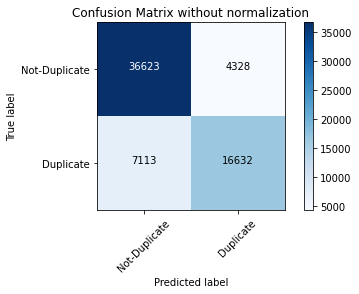

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Creating Confusion Matrix for Evaluting Not Dupicate and Duplicate
y_test = Y_test
y_pred = Testing_Predictions_bool

cnf_matrix = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

# Creting non-profit Confusion Matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not-Duplicate','Duplicate'],
                      title='Confusion Matrix without normalization')

Accuracy:  82.31575367874366 %
Recall:  0.700442198357549
Precision:  0.7935114503816794
F1 score:  0.7440778436416507
ROC AUC score:  0.7973774567768794
Average precision-recall score: 82.02 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=82.02')

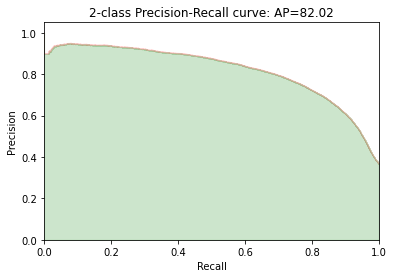

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
import plotly

# Here we are eavluting our model by calculating Accuracy, Recall, Precision, F1 Score and ROC AUC Score.
# FYI ROC AUC Score used to measure the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
y_test = Y_test
y_pred = Testing_Predictions_bool
y_pred_prob = Testing_Predictions

rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy: ", acc*100,'%')
print("Recall: ", rec)
print("Precision: ", prec)
print("F1 score: ", f1)
print("ROC AUC score: ", roc_auc)


from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred_prob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision*100),'%')

import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.step(recall, precision, color='red', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='green')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision*100))

### As can be seen, applying modern NLP approaches and algorithms enhanced our accuracy, and our model now performs significantly better than previously.

# **Thank You**